In [1]:
import fastf1 as ff1
from fastf1 import plotting

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm

import numpy as np

plotting.setup_mpl()

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
race = ff1.get_session(2023, 'Austrian', 'R')
laps = race.load_laps()

api         WARNING 	

NO CACHE! Api caching has not been enabled! 
	It is highly recommended to enable this feature for much faster data loading!
	Use `fastf1.Cache.enable_cache('path/to/cache/')`

C:\Users\Imran\anaconda3\lib\site-packages\fastf1\core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Austrian Grand Prix - Race [v2.3.0]
api            INFO 	Fetching driver list...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api         WARNING 	Driver 20: Encountered 1 timing integrity error(s) near lap(s): [34].
This might be a bug and should be reported.
api            INFO 	Fetching timing app data...
core           INFO 	Processing timing data...
api            INFO 	Fetching session status data...
api            INFO 	Fetching track status data...
api          

In [4]:
laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()
laps = laps.loc[(laps['PitOutTime'].isnull() & laps['PitInTime'].isnull())]

In [5]:
q75, q25 = laps['LapTimeSeconds'].quantile(0.75), laps['LapTimeSeconds'].quantile(0.25)

intr_qr = q75 - q25

laptime_max = q75 + (1.5 * intr_qr) 
laptime_min = q25 - (1.5 * intr_qr) 

laps.loc[laps['LapTimeSeconds'] < laptime_min, 'LapTimeSeconds'] = np.nan
laps.loc[laps['LapTimeSeconds'] > laptime_max, 'LapTimeSeconds'] = np.nan

In [6]:
drivers_to_visualize = ['VER', 'LEC', 'PER', 'SAI', 'NOR', 'ALO', 'HAM', 'RUS', 'GAS', 'STR']

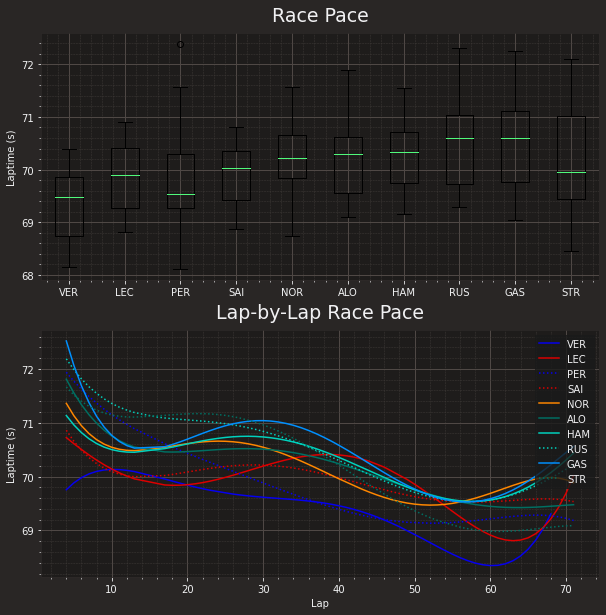

In [7]:
visualized_teams = []

plt.rcParams['figure.figsize'] = [10, 10]

fig, ax = plt.subplots(2)

laptimes = [laps.pick_driver(x)['LapTimeSeconds'].dropna() for x in drivers_to_visualize] 

ax[0].boxplot(laptimes, labels=drivers_to_visualize)

ax[0].set_title('Race Pace')
ax[0].set(ylabel = 'Laptime (s)')

for driver in drivers_to_visualize:
    driver_laps = laps.pick_driver(driver)[['LapNumber', 'LapTimeSeconds', 'Team']]
    
    driver_laps = driver_laps.dropna()
    
    team = pd.unique(driver_laps['Team'])[0]
    
    x = driver_laps['LapNumber']
    
    poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], 5)
    y_poly = np.poly1d(poly)(driver_laps['LapNumber'])
    
    linestyle = '-' if team not in visualized_teams else ':'
    
    ax[1].plot(x, y_poly, label=driver, color=ff1.plotting.team_color(team), linestyle=linestyle)
    
    ax[1].set(ylabel = 'Laptime (s)')
    ax[1].set(xlabel = 'Lap')
    
    ax[1].set_title('Lap-by-Lap Race Pace')

    ax[1].legend()
    
    visualized_teams.append(team)
    
    plt.savefig('2023 Austrian GP Points Finisher Race Pace Analysis.png', dpi=600)